# Toy Model: Filtering

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
plt.rcParams['savefig.dpi'] = 400 
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.sbin import suppression_factor, suppression_factor_simple, suppression_simulation
from sbin import parameters

## Read in the data

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [2]:
# read in my kois table
with open('tables/kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# confirmed planets only
allbin = Table.read('tables/plan_allbinall.mrt', format='ascii.mrt').to_pandas()

mask = allbin['Alternate'].str.match(r'^KOI\d+(?:\.\d+)?$', na=False)
tmp = allbin.loc[mask].copy()
tmp['KOI'] = tmp['Alternate'].str.extract(r'KOI0*(\d+)', expand=False).astype(int)
db=tmp.merge(kois, on='KOI', suffixes=['','_y'])

In [4]:
q = db['Mass']/db['Mass_1']
RL = 0.49*q**(2/3)/(0.6*q**(2/3)+np.log(1+q**(1/3))) # verified against https://dev.adsabs.harvard.edu/scan/
disk = RL * db['semi-major']

db['DiskAU'] = disk

db['SnowAU'] = 0.00465*0.5*(db['teff']/170.)**2 # for T_eq = 170K

In [31]:
np.median((disk/db['semi-major']).unique())

0.41567533820371116

## Define subsamples

In [5]:
# period and stellar limits
plim = (db['koi_period'] < 100)
       

# filter the binaries
db_filtered = db[(db['koi_prad'] < parameters.radius_limit) & plim].copy()
close = db_filtered['semi-major']<100
good = (db_filtered['koi_prad_err1'] - db_filtered['koi_prad_err2'])/db_filtered['koi_prad'] < parameters.max_radius_error




In [6]:
bundle = {
    "db_filtered": db_filtered,      # pandas DataFrame
    "close": close,                  # boolean Series
    "good": good,                    # boolean Series
}

with open("filtered_data_thebault.pkl", "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)


## Get numbers for paper

In [12]:
def calc_statistics(catalog, prad_col = 'Rp', star_col='KOI', MTPS=False):
    
    n_planets = float(len(catalog))
    print( "Number of planets: ", int(n_planets))
    print( "Number of stars: ", len(catalog[star_col].unique()))
    
    n_SEs = float(len(catalog.loc[catalog[prad_col]<parameters.radius_valley]))
    print("Frac super-Earths/n_planets: ", n_SEs/n_planets, "+-", np.sqrt(n_SEs)/n_planets)
    
    if MTPS:
        planet_counts = catalog.groupby(star_col).size().reset_index(name='n_planets')
        stps = len(planet_counts.loc[planet_counts['n_planets']==1])
        mtps = len(planet_counts.loc[planet_counts['n_planets']>1])
        print("Frac MTPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))


# ----------------------------------------------
# Print all the samples and sub-samples
# ----------------------------------------------

        
print("BINARIES\n\n All")
calc_statistics(db_filtered[good], prad_col='koi_prad')

print("\n Close (error good)")
calc_statistics(db_filtered[good & close], prad_col='koi_prad')

print("\n Wide (error good)")
calc_statistics(db_filtered[good & ~close], prad_col='koi_prad')

print("\n Close (any error)")
calc_statistics(db_filtered[close], prad_col='koi_prad', MTPS=True)

print("\n Wide (any error)")
calc_statistics(db_filtered[~close], prad_col='koi_prad', MTPS=True)

BINARIES

 All
Number of planets:  315
Number of stars:  196
Frac super-Earths/n_planets:  0.6063492063492063 +- 0.04387388876535001

 Close (error good)
Number of planets:  91
Number of stars:  56
Frac super-Earths/n_planets:  0.7692307692307693 +- 0.09194066225649182

 Wide (error good)
Number of planets:  224
Number of stars:  140
Frac super-Earths/n_planets:  0.5401785714285714 +- 0.049107142857142856

 Close (any error)
Number of planets:  101
Number of stars:  63
Frac super-Earths/n_planets:  0.7227722772277227 +- 0.08459409648829239
Frac MTPS:  25 38 0.3968253968253968 +- 0.07936507936507936

 Wide (any error)
Number of planets:  287
Number of stars:  188
Frac super-Earths/n_planets:  0.5365853658536586 +- 0.043239280996483824
Frac MTPS:  56 132 0.2978723404255319 +- 0.039804865816744056


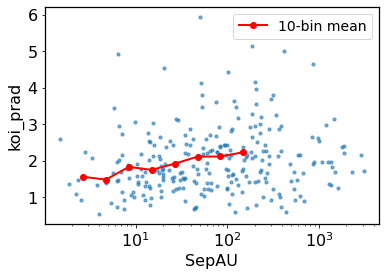

In [24]:
# biggest planet
max_rp = db_filtered.loc[db_filtered.groupby('KOI')['koi_prad'].idxmax()].reset_index(drop=True)

# scatter 
y = max_rp['DiskAU']/max_rp['SnowAU']
plt.scatter(y, max_rp['koi_prad'], s=10, alpha=0.6)
plt.xscale('log')
plt.xlabel('SepAU'); plt.ylabel('koi_prad')

# 10 log-spaced bins (11 edges)
#bins = np.logspace(np.log10(20), np.log10(3000), 11)
bins = np.logspace(np.log10(2), np.log10(200), 9)

# assign points to bins
bin_idx = np.digitize(y.values, bins)

# keep only points inside [bins[0], bins[-1]]
valid = (bin_idx >= 1) & (bin_idx <= len(bins) - 1)
tmp = max_rp.loc[valid, ['koi_prad']].copy()
tmp['bin'] = bin_idx[valid]

# mean Rppri per bin, ensure length 10 (fill missing bins with NaN)
means = tmp.groupby('bin')['koi_prad'].mean().reindex(range(1, len(bins))).values

# plot at bin centers (geometric mean of edges)
centers = np.sqrt(bins[:-1] * bins[1:])
plt.plot(centers, means, color='red', linewidth=2, marker='o', label='10-bin mean')

plt.legend()
plt.show()